In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf


2025-12-10 21:57:58.669044: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-10 21:55:15.529517: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-10 21:55:17.573237: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

I0000 00:00:1765400184.135598    1946 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


2025-12-10 21:56:26.173234: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-12-10 21:56:26.187856: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-12-10 21:56:26.188523: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Saturday June 3, 6:30pm The Neptune<br /><br />Monday June 5, 4:30pm The Neptune<br /><br />Few celebrations of ethnic and cultural identity succeed as mightily as Carlos Saura\'s brilliant interpretation of Isaac Albeniz\' masterpiece Iberia Suite. At the approach of its centennial, Saura drew together an unprecedented wealth of talent from the Spanish performing arts community to create this quintessential love song to their homeland. The twelve "impressions" of the suite are presented without narrative in stark surroundings, allowing the power of each performance to explode before Saura\'s camera. Creative use of large flats and mirrors, moved throughout the set, combined with screens, shadows, fire, rain and rear projection add glorious dramatic effects to the varied selections of song, dance and instrumental performance. Photographs of Albeniz reappear throughout the program, connecting the passion of the music to its great creator. Saura encompasses all Spaniards on hi

2025-12-10 21:56:31.885896: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-12-10 21:56:31.890722: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:50]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but',
       'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be',
       'one', 'its', 'at', 'all', 'by', 'an', 'they', 'from', 'who', 'so',
       'like', 'her', 'just', 'or', 'about', 'has', 'if', 'out', 'some',
       'there', 'what'], dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   1, 442, ...,   0,   0,   0],
       [ 10, 153, 118, ...,   0,   0,   0],
       [ 29, 882,  12, ...,   0,   0,   0]], shape=(3, 1002))

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Saturday June 3, 6:30pm The Neptune<br /><br />Monday June 5, 4:30pm The Neptune<br /><br />Few celebrations of ethnic and cultural identity succeed as mightily as Carlos Saura\'s brilliant interpretation of Isaac Albeniz\' masterpiece Iberia Suite. At the approach of its centennial, Saura drew together an unprecedented wealth of talent from the Spanish performing arts community to create this quintessential love song to their homeland. The twelve "impressions" of the suite are presented without narrative in stark surroundings, allowing the power of each performance to explode before Saura\'s camera. Creative use of large flats and mirrors, moved throughout the set, combined with screens, shadows, fire, rain and rear projection add glorious dramatic effects to the varied selections of song, dance and instrumental performance. Photographs of Albeniz reappear throughout the program, connecting the passion of the music to its great creator. Saura encompasses all Spaniards on 

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [14]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text], dtype=tf.string))
print(predictions[0])

2025-12-10 21:57:03.638515: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[-0.00294321]


In [15]:
# predict on a sample text with padding

text_with_padding = sample_text + "the " * 2000
predictions = model.predict(tf.constant([text_with_padding], dtype=tf.string))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
[-0.01965155]


In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [17]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 45s -310159us/step - accuracy: 0.6076 - loss: 0.6114 - val_accuracy: 0.7906 - val_loss: 0.4265
Epoch 2/10
365/391 ━━━━━━━━━━━━━━━━━━━━ 14s 552ms/step - accuracy: 0.8126 - loss: 0.4065

2025-12-10 21:58:38.108905: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - accuracy: 0.8270 - loss: 0.3826 - val_accuracy: 0.8484 - val_loss: 0.3874
Epoch 3/10
376/391 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step - accuracy: 0.8470 - loss: 0.3477

2025-12-10 21:59:16.867006: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.8492 - loss: 0.3409 - val_accuracy: 0.8443 - val_loss: 0.3363
Epoch 4/10
371/391 ━━━━━━━━━━━━━━━━━━━━ 10s 543ms/step - accuracy: 0.8600 - loss: 0.3252

2025-12-10 21:59:57.481458: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.8583 - loss: 0.3270 - val_accuracy: 0.8573 - val_loss: 0.3342
Epoch 5/10
384/391 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - accuracy: 0.8601 - loss: 0.3222 

2025-12-10 22:00:35.979417: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 38s 98ms/step - accuracy: 0.8603 - loss: 0.3209 - val_accuracy: 0.8583 - val_loss: 0.3267
Epoch 6/10
372/391 ━━━━━━━━━━━━━━━━━━━━ 10s 530ms/step - accuracy: 0.8656 - loss: 0.3172

2025-12-10 22:01:11.826387: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 36s 92ms/step - accuracy: 0.8661 - loss: 0.3133 - val_accuracy: 0.8557 - val_loss: 0.3220
Epoch 7/10
386/391 ━━━━━━━━━━━━━━━━━━━━ 2s 521ms/step - accuracy: 0.8659 - loss: 0.3065 

2025-12-10 22:01:50.856758: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 99ms/step - accuracy: 0.8682 - loss: 0.3069 - val_accuracy: 0.8573 - val_loss: 0.3203
Epoch 8/10
358/391 ━━━━━━━━━━━━━━━━━━━━ 18s 551ms/step - accuracy: 0.8646 - loss: 0.3084

2025-12-10 22:02:28.300218: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.8640 - loss: 0.3107 - val_accuracy: 0.8609 - val_loss: 0.3410
Epoch 9/10
352/391 ━━━━━━━━━━━━━━━━━━━━ 22s 568ms/step - accuracy: 0.8686 - loss: 0.3024

2025-12-10 22:03:09.301474: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ 205s 524ms/step - accuracy: 0.8680 - loss: 0.3026 - val_accuracy: 0.8552 - val_loss: 0.3208
Epoch 10/10
343/391 ━━━━━━━━━━━━━━━━━━━━ 27s 581ms/step - accuracy: 0.8737 - loss: 0.2967 

2025-12-10 22:03:50.015913: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 ━━━━━━━━━━━━━━━━━━━━ -123s 105ms/step - accuracy: 0.8700 - loss: 0.3019 - val_accuracy: 0.8630 - val_loss: 0.3252


2025-12-10 22:03:51.556265: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 49ms/step - accuracy: 0.8637 - loss: 0.3244 
Test Loss: 0.32435470819473267
Test Accuracy: 0.8636800050735474


(0.0, 0.6268900617957115)

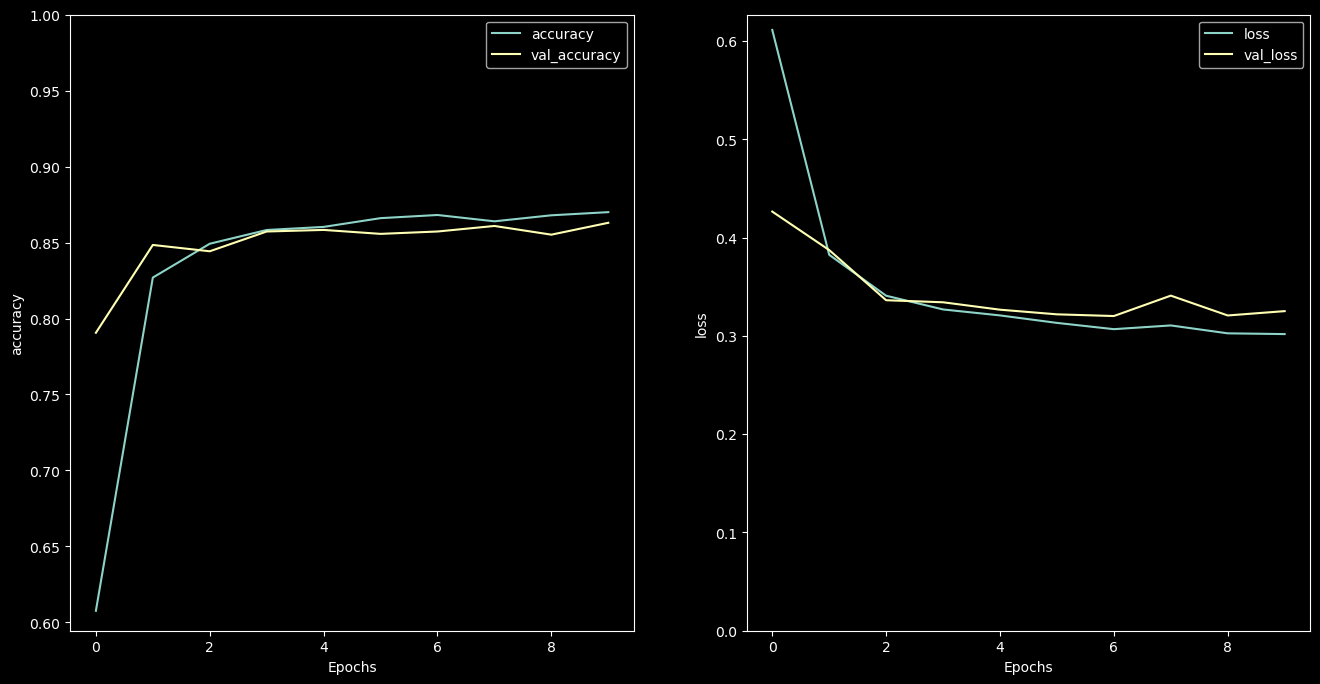

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [21]:
sample_positive_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
sample_negative_text = ('The movie awful. Waste of time and money.'
               'The director should consider different career path.')
predictions = model.predict(tf.constant([sample_positive_text,sample_negative_text], dtype=tf.string))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
[[ 0.9146762]
 [-3.2477403]]


In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 83s 201ms/step - accuracy: 0.5562 - loss: 0.6543 - val_accuracy: 0.7656 - val_loss: 0.5291
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 207ms/step - accuracy: 0.8168 - loss: 0.4195 - val_accuracy: 0.8365 - val_loss: 0.3662
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 79s 201ms/step - accuracy: 0.8461 - loss: 0.3571 - val_accuracy: 0.8198 - val_loss: 0.3666
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 74s 189ms/step - accuracy: 0.8572 - loss: 0.3338 - val_accuracy: 0.8026 - val_loss: 0.3837
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 69s 175ms/step - accuracy: 0.8571 - loss: 0.3280 - val_accuracy: 0.8516 - val_loss: 0.3347
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 68s 175ms/step - accuracy: 0.8652 - loss: 0.3173 - val_accuracy: 0.8594 - val_loss: 0.3249
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 68s 173ms/step - accuracy: 0.8658 - loss: 0.3140 - val_accuracy: 0.8568 - val_loss: 0.3188
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 63s 162ms/step - accuracy: 0.8644 - loss: 0

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 32s 82ms/step - accuracy: 0.8625 - loss: 0.3351
Test Loss: 0.3351210057735443
Test Accuracy: 0.8625199794769287


In [30]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
[[-1.98693]]


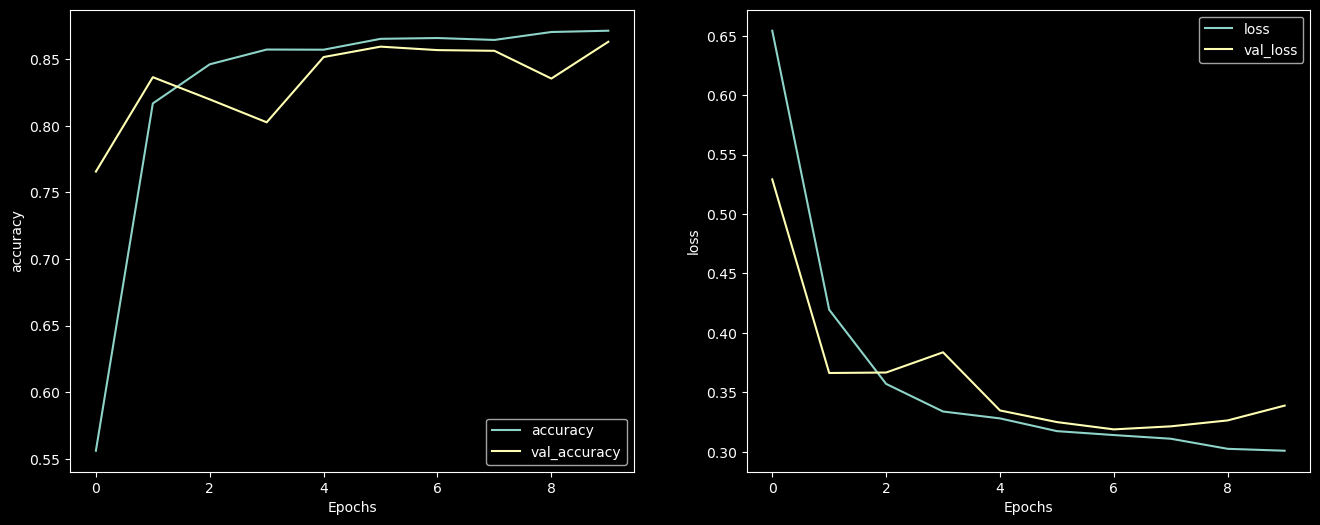

In [28]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.show()

In [29]:
model.save("rnn_model.keras")